In [50]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc
using Test

  Activating environment at `~/桌面/optimal-control-homework/HW1_S24-main/Project.toml`
Precompiling project...
  ✓ LoopThrottle
  ✓ TypeSortedCollections
  ✓ WoodburyMatrices
  ✓ Ratios
  ✓ LightXML
  ✓ UnsafeArrays
  ✓ Observables
  ✓ FunctionalCollections
  ✓ Mustache
  ✓ AxisAlgorithms
  ✓ LLVMOpenMP_jll
  ✓ OffsetArrays
  ✓ Widgets
  ✓ Pixman_jll
  ✓ FileIO
  ✓ Lazy
  ✓ Cairo_jll
  ✓ WebIO
  ✓ HarfBuzz_jll
  ✓ Interpolations
  ✓ CSSUtil
  ✓ RigidBodyDynamics
  ✓ Pango_jll
  ✓ libass_jll
  ✓ JSExpr
  ✓ libdecor_jll
  ✓ FFMPEG_jll
  ✓ FFMPEG
  ✓ GLFW_jll
  ✓ MechanismGeometries
  ✓ Knockout
  ✓ GR_jll
  ✓ Blink
  ✓ GR
  ✓ InteractBase
  ✓ MeshCat
  ✓ MeshCatMechanisms
  ✓ JLD2
  ✓ Plots
  39 dependencies successfully precompiled in 41 seconds (168 already precompiled)
  13 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


## Julia Warmup
Just like Python, Julia lets you do the following:

In [51]:
let  
    x = [1,2,3]
    @show x 
    y = x # NEVER DO THIS, EDITING ONE WILL NOW EDIT BOTH 
    
    y[3] = 100 # this will now modify both y and x 
    x[1] = 300 # this will now modify both y and x 
    
    @show y 
    @show x 
end

x = [1, 2, 3]
y = [300, 2, 100]
x = [300, 2, 100]


3-element Vector{Int64}:
 300
   2
 100

In [52]:
# to avoid this, here are two alternatives 
let  
    x = [1,2,3]
    @show x 
    
    y1 = 1*x         # this is fine 
    y2 = deepcopy(x) # this is also fine 
    
    x[2] = 200 # only edits x 
    y1[1] = 400 # only edits y1 
    y2[3] = 100 # only edits y2 
    
    @show x
    @show y1 
    @show y2 
end

x = [1, 2, 3]
x = [1, 200, 3]
y1 = [400, 2, 3]
y2 = [1, 2, 100]


3-element Vector{Int64}:
   1
   2
 100

### Optional function arguments 
We can have optional keyword arguments for functions in Julia, like the following:

In [53]:
## optional arguments in functions 

# we can have functions with optional arguments after a ; that have default values 
let 
    function f1(a, b; c=4, d=5)
        @show a,b,c,d
    end
    
    f1(1,2)               # this means c and d will take on default value 
    f1(1,2;c = 100,d = 2) # specify c and d 
    f1(1,2;d = -30)       # or we can only specify one of them 
end

(a, b, c, d) = (1, 2, 4, 5)
(a, b, c, d) = (1, 2, 100, 2)
(a, b, c, d) = (1, 2, 4, -30)


(1, 2, 4, -30)

## Q1: Integration (25 pts)
In this question we are going to integrate the equations of motion for a double pendulum using multiple explicit and implicit integrators. We will write a generic simulation function for each of the two categories (explicit and implicit), and compare 6 different integrators. 

The continuous time dynamics of the cartpole are written as a function:

$$\dot{x} = f(x)$$

In the code you will see `xdot = dynamics(params, x)`. 

### Part A (10 pts): Explicit Integration
Here we are going to implement the following explicit integrators: 

- Forward Euler (explicit)
- Midpoint (explicit)
- RK4 (explicit)

In [54]:
# these two functions are given, no TODO's here 
function double_pendulum_dynamics(params::NamedTuple, x::Vector)
    # continuous time dynamics for a double pendulum given state x,
    # also known as the "equations of motion". 
    # returns the time derivative of the state, ẋ (dx/dt)

    # the state is the following:
    θ1,θ̇1,θ2,θ̇2 = x

    # system parameters
    m1, m2, L1, L2, g = params.m1, params.m2, params.L1, params.L2, params.g

    # dynamics
    c = cos(θ1-θ2)
    s = sin(θ1-θ2)

    ẋ = [
        θ̇1;
        ( m2*g*sin(θ2)*c - m2*s*(L1*c*θ̇1^2 + L2*θ̇2^2) - (m1+m2)*g*sin(θ1) ) / ( L1 *(m1+m2*s^2) );
        θ̇2;
        ((m1+m2)*(L1*θ̇1^2*s - g*sin(θ2) + g*sin(θ1)*c) + m2*L2*θ̇2^2*s*c) / (L2 * (m1 + m2*s^2));
        ]

    return ẋ
end
function double_pendulum_energy(params::NamedTuple, x::Vector)::Real
    # calculate the total energy (kinetic + potential) of a double pendulum given a state x 


    # the state is the following:
    θ1,θ̇1,θ2,θ̇2 = x

    # system parameters
    m1, m2, L1, L2, g = params.m1, params.m2, params.L1, params.L2, params.g

    # cartesian positions/velocities of the masses
    r1 = [L1*sin(θ1), 0, -params.L1*cos(θ1) + 2]
    r2 = r1 + [params.L2*sin(θ2), 0, -params.L2*cos(θ2)]
    v1 = [L1*θ̇1*cos(θ1), 0, L1*θ̇1*sin(θ1)]
    v2 = v1 + [L2*θ̇2*cos(θ2), 0, L2*θ̇2*sin(θ2)]

    # energy calculation
    kinetic = 0.5*(m1*v1'*v1 + m2*v2'*v2)
    potential = m1*g*r1[3] + m2*g*r2[3]
    return kinetic + potential
end

double_pendulum_energy (generic function with 1 method)

Now we are going to simulate this double pendulum by integrating the equations of motion with the simplest explicit integrator, the Forward Euler method:

$$x_{k+1} = x_k + \Delta t \cdot f({x}_k) \quad \quad \text{Forward Euler (explicit)}$$

In [55]:
"""
    x_{k+1} = forward_euler(params, dynamics, x_k, dt)

Given `ẋ = dynamics(params, x)`, take in the current state `x` and integrate it forward `dt`
using Forward Euler method. 
"""
function forward_euler(params::NamedTuple, dynamics::Function, x::Vector, dt::Real)::Vector
    # ẋ = dynamics(params, x)
    # TODO: implement forward euler 
    # x_return=zeros(4)
    x_return=x+dt*dynamics(params, x)
    
    
    
    return x_return
end

forward_euler

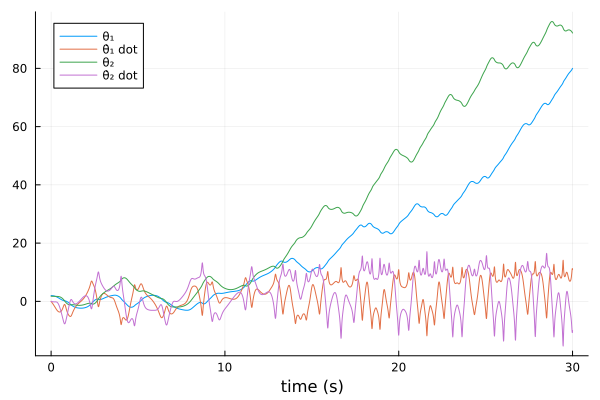

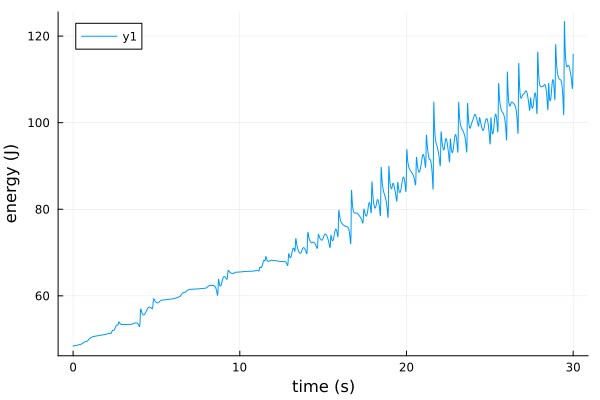

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8711


Test Summary: | Pass  Total
forward euler |    2      2


Test.DefaultTestSet("forward euler", Any[], 2, false, false)

In [56]:
include(joinpath(@__DIR__, "animation.jl"))

@testset "forward euler" begin

    # parameters for the simulation
    params = (
        m1 = 1.0,
        m2 = 1.0,
        L1 = 1.0,
        L2 = 1.0,
        g = 9.8
    )

    # initial condition
    x0 = [pi/1.6; 0; pi/1.8; 0]

    # time step size (s)
    dt = 0.01
    tf = 30.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    
    # store the trajectory in a vector of vectors
    X = [zeros(4) for i = 1:N]
    X[1] = 1*x0 

    # TODO: simulate the double pendulum with `forward_euler` 
    # X[k] = `x_k`, so X[k+1] = forward_euler(params, double_pendulum_dynamics, X[k], dt)
    for i =2:N
        X[i]=forward_euler(params,double_pendulum_dynamics,X[i-1],dt)
    end

    # calculate energy 
    E = [double_pendulum_energy(params,x) for x in X]

    @test norm(X[end]) > 1e-10   # make sure all X's were updated
    @test 2 < (E[end]/E[1]) < 3  # energy should be increasing

    # plot state history, energy history, and animate it
    display(plot(t_vec, hcat(X...)',xlabel = "time (s)", label = ["θ₁" "θ̇₁ dot" "θ₂" "θ̇₂ dot"]))
    display(plot(t_vec, E, xlabel = "time (s)", ylabel = "energy (J)"))
    meshcat_animate(params,X,dt,N)
    
    
end

Now let's implement the next two integrators:

**Midpoint:**
$$ \begin{align} x_m &= x_k + \frac{\Delta t}{2} \cdot f(x_k) \\
              x_{k+1} &= x_k + \Delta t \cdot f({x}_m)\end{align}$$

**RK4:**
$$\begin{align}k_1 &= \Delta t \cdot f({x}_k) \\
k_2 &= \Delta t \cdot f(x_k + k_1/2)  \\ 
k_3 &= \Delta t \cdot f(x_k + k_2/2)  \\ 
k_4 &= \Delta t \cdot f(x_k + k_3)  \\
x_{k+1} &= x_k + (1/6)\cdot (k_1 + 2k_2 + 2k_3 + k_4)\end{align} $$

In [57]:
function midpoint(params::NamedTuple, dynamics::Function, x::Vector, dt::Real)::Vector
    # TODO: implement explicit midpoint
    
   
    ẋ=dynamics(params,x)
    x_m=x+(dt/2)*ẋ

    x_return=x+dt*dynamics(params,x_m)
    
    
    return x_return
end
function rk4(params::NamedTuple, dynamics::Function, x::Vector, dt::Real)::Vector
    # TODO: implement RK4
    x_return=zeros(4)
    
    k1=dt*dynamics(params,x)
    k2=dt*dynamics(params,x+k1/2)
    k3=dt*dynamics(params,x+k2/2)
    k4=dt*dynamics(params,x+k3)
    x_return=x+(k1+2*k2+2*k3+k4)/6
    
    
    
    return x_return
end

rk4 (generic function with 1 method)

In [58]:
function simulate_explicit(params::NamedTuple,dynamics::Function,integrator::Function,x0::Vector,dt::Real,tf::Real)
    # TOOD: update this function to simulate dynamics forward
    # with the given explicit integrator 
    
    
    # take in 
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(length(x0)) for i = 1:N]
    X[1] = x0
    
    # TODO: simulate X forward
    for i =2:N
        X[i]=integrator(params,dynamics,X[i-1],dt)
    end
    
    # return state history X and energy E 
    E = [double_pendulum_energy(params,x) for x in X]
    return X, E
end

simulate_explicit (generic function with 1 method)

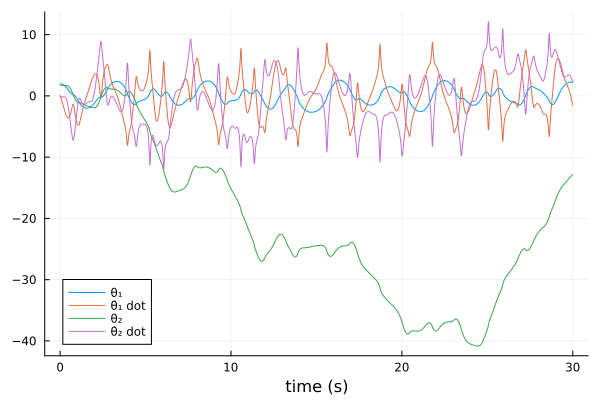

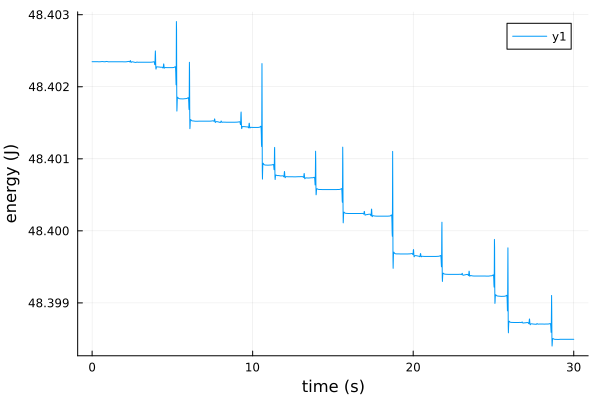

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8712


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x73, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "rod2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x72, 0x6f, 0x64, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x73, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "rod1" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x72, 0x6f, 0x64, 0x31], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8712))

In [59]:
# initial condition
const x0 = [pi/1.6; 0; pi/1.8; 0]

const params = (
    m1 = 1.0,
    m2 = 1.0,
    L1 = 1.0,
    L2 = 1.0,
    g = 9.8
)
dt = 0.01
tf = 30.0 
t_vec = 0:dt:tf
N = length(t_vec)
X,E=simulate_explicit(params,double_pendulum_dynamics,rk4,x0,0.01,30.0)

 # plot state history, energy history, and animate it
display(plot(t_vec, hcat(X...)',xlabel = "time (s)", label = ["θ₁" "θ̇₁ dot" "θ₂" "θ̇₂ dot"]))
display(plot(t_vec, E, xlabel = "time (s)", ylabel = "energy (J)"))
meshcat_animate(params,X,dt,N)

### Part B (10 pts): Implicit Integrators

Explicit integrators work by calling a function with $x_k$ and $\Delta t$ as arguments, and returning $x_{k+1}$ like this:

$$x_{k+1} = f_{explicit}(x_k,\Delta t)$$

Implicit integrators on the other hand have the following relationship between the state at $x_k$ and $x_{k+1}$:

$$f_{implicit}(x_k, x_{k+1}, \Delta t) = 0$$

This means that if we want to get $x_{k+1}$ from $x_k$, we have to solve for a $x_{k+1}$ that satisfies the above equation. This is a rootfinding problem in $x_{k+1}$ (our unknown), so we juse have to use Newton's method.

Here are the three implicit integrators we are looking at, the first being Backward Euler (1st order):

$$f(x_k,x_{k+1},\Delta t) = x_k + \Delta t \cdot \dot{x}_{k+1} - x_{k+1} = 0 \quad \quad \text{Backward Euler}$$

Implicit Midpoint (2nd order)
$$ \begin{align} x_{k+1/2} &= \frac{1}{2}(x_k + x_{k+1})\\ f(x_k,x_{k+1},\Delta t) &= x_k + {\Delta t} \cdot \dot{x}_{k+1/2} - x_{k+1} = 0\quad \quad \text{Implicit Midpoint} \end{align} $$

Hermite Simpson (3rd order)
$$ \begin{align} x_{k+1/2} &= \frac{1}{2}(x_k + x_{k+1}) + \frac{\Delta t}{8}(\dot{x}_k - \dot{x}_{k+1})\\ f(x_k,x_{k+1},\Delta t) &= x_k + \frac{\Delta t}{6} \cdot (\dot{x}_k + 4\dot{x}_{k+1/2} + \dot{x}_{k+1}) - x_{k+1}= 0\quad \quad \text{Hermite-Simpson} \end{align} $$

When you implement these integrators, you will update the functions such that they take in a dynamics function, $x_k$ and $x_{k+1}$, and return the residuals described above. We are NOT solving these yet, we are simply returning the residuals for each implicit integrator that we want to be 0.
<!-- $$ f(x_k,x_{k+1},\Delta t) = x_k + \frac{\Delta t}{2} \cdot \dot{x}_{k+1/2} - x_{k+1} - x_{k+1}= 0 \quad \quad \text{Hermite-Simpson}$$ -->

In [62]:
# since these are explicit integrators, these function will return the residuals described above
# NOTE: we are NOT solving anything here, simply return the residuals 
function backward_euler(params::NamedTuple, dynamics::Function, x1::Vector, x2::Vector, dt::Real)::Vector
    return x1+dt*dynamics(params,x2)-x2
end
function implicit_midpoint(params::NamedTuple, dynamics::Function, x1::Vector, x2::Vector, dt::Real)::Vector
    x_mid=(x1+x2)/2
    return x1+dt*dynamics(params,x_mid)-x2
end
function hermite_simpson(params::NamedTuple, dynamics::Function, x1::Vector, x2::Vector, dt::Real)::Vector
    x_mid=(x1+x2)/2+dt*(dynamics(params,x1)-dynamics(params,x2))/8
    return x1+dt*(dynamics(params,x1)+dynamics(params,4*x_mid)+dynamics(params,x2))/6-x2
end

hermite_simpson (generic function with 1 method)

In [64]:
# TODO
# this function takes in a dynamics function, implicit integrator function, and x1 
# and uses Newton's method to solve for an x2 that satsifies the implicit integration equations
# that we wrote about in the functions above
function implicit_integrator_solve(params::NamedTuple, dynamics::Function, implicit_integrator::Function, x1::Vector, dt::Real;tol = 1e-13, max_iters = 10)::Vector

    # initialize guess
    x2 = 1*x1

    # TODO: use Newton's method to solve for x2 such that residual for the integrator is 0
    # DO NOT USE A WHILE LOOP 
    for i = 1:max_iters
        r=implicit_integrator(params,dynamics,x1,x2,dt)
        if norm(r)<tol
            return x2
        else
            #use Newton's method  
            #goal f(x)=0 rootfinding  x_k+1=x_k-▿f\f
            λ=FD.jacobian(dx -> implicit_integrator(params,dynamics,x1,dx,dt),x2)
            x2=x2-λ\r
        end
            
        

        
        # TODO: return x2 when the norm of the residual is below tol 

        
    end
    error("implicit integrator solve failed")
end    

implicit_integrator_solve (generic function with 1 method)

In [65]:
@testset "implicit integrator check" begin 
    
    dt = 1e-1
    x1 = [.1,.2,.3,.4]
    
    for integrator in [backward_euler, implicit_midpoint, hermite_simpson]
        println("-----testing $integrator ------")
        x2 = implicit_integrator_solve(params, double_pendulum_dynamics, integrator, x1, dt)
        @test norm(integrator(params, double_pendulum_dynamics, x1, x2, dt)) < 1e-10
    end
    
end

-----testing backward_euler ------
-----testing implicit_midpoint ------
-----testing hermite_simpson ------
Test Summary:             | Pass  Total
implicit integrator check |    3      3


Test.DefaultTestSet("implicit integrator check", Any[], 3, false, false)

In [ ]:
function simulate_implicit(params::NamedTuple,dynamics::Function,implicit_integrator::Function,x0::Vector,dt::Real,tf::Real; tol = 1e-13)
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(length(x0)) for i = 1:N]
    X[1] = x0
    
    # TODO: do a forward simulation with the selected implicit integrator 
    # hint: use your `implicit_integrator_solve` function

    E = [double_pendulum_energy(params,x) for x in X]
    @assert length(X)==N
    @assert length(E)==N
    return X, E
end

In [ ]:
function max_err_E(E)
    E0 = E[1]
    err = abs.(E .- E0)
    return maximum(err)
end
function get_explicit_energy_error(integrator::Function, dts::Vector)
    [max_err_E(simulate_explicit(params,double_pendulum_dynamics,integrator,x0,dt,tf)[2]) for dt in dts]
end
function get_implicit_energy_error(integrator::Function, dts::Vector)
    [max_err_E(simulate_implicit(params,double_pendulum_dynamics,integrator,x0,dt,tf)[2]) for dt in dts]
end


const tf = 2.0
let 
    # here we compare everything 
    dts = [1e-3,1e-2,1e-1]
    explicit_integrators = [forward_euler, midpoint, rk4]
    implicit_integrators = [backward_euler, implicit_midpoint, hermite_simpson]

    explicit_data = [get_explicit_energy_error(integrator, dts) for integrator in explicit_integrators]
    implicit_data = [get_implicit_energy_error(integrator, dts) for integrator in implicit_integrators]

    plot(dts, hcat(explicit_data...),label = ["Forward Euler" "Midpoint" "RK4"],xaxis=:log10,yaxis=:log10, xlabel = "Δt (s)", ylabel = "Energy Error")
    plot!(dts, hcat(implicit_data...),ls = :dash, label = ["Backward Euler" "Implicit Midpoint" "Hermite Simpson"])
    plot!(legend=:bottomright)
end
    

What we can see above is the maximum energy error for each of the integration methods. In general, the implicit methods of the same order are slightly better than the explicit ones. 

In [ ]:
@testset "energy behavior" begin 
    
    # simulate with all integrators
    dt = 0.01
    t_vec = 0:dt:tf
    E1 = simulate_explicit(params,double_pendulum_dynamics,forward_euler,x0,dt,tf)[2]
    E2 = simulate_implicit(params,double_pendulum_dynamics,backward_euler,x0,dt,tf)[2]
    E3 = simulate_implicit(params,double_pendulum_dynamics,implicit_midpoint,x0,dt,tf)[2]
    E4 = simulate_implicit(params,double_pendulum_dynamics,hermite_simpson,x0,dt,tf)[2]
    E5 = simulate_explicit(params,double_pendulum_dynamics,midpoint,x0,dt,tf)[2]
    E6 = simulate_explicit(params,double_pendulum_dynamics,rk4,x0,dt,tf)[2]
    
    # plot forward/backward euler and implicit midpoint 
    plot(t_vec,E1, label = "Forward Euler (explicit)")
    plot!(t_vec,E2, label = "Backward Euler (implicit)")
    display(plot!(t_vec,E3, label = "Implicit Midpoint",xlabel = "Time (s)", ylabel="Energy (J)"))

    # test energy behavior
    E0 = E1[1]
    
    @test 2.5  < (E1[end] - E0) < 3.0
    @test -3.0 < (E2[end] - E0) < -2.5  
    @test abs(E3[end] - E0) < 1e-2
    @test abs(E0 - E4[end]) < 1e-4
    @test abs(E0 - E5[end]) < 1e-1 
    @test abs(E0 - E6[end]) < 1e-4
end


Another important takeaway from these integrators is that explicit Euler results in unstable behavior (as shown here by the growing energy), and implicit Euler results in artificial damping (losing energy). Implicit midpoint however maintains the correct energy. Even though the solution from implicit midpoint will vary from the initial energy, it does not move secularly one way or the other. 

## Part C (5 pts): One sentence short answer

1. Describe the energy behavior of each integrator. Are there any that are clearly unstable?

**Put ONE SENTENCE answer here**